#### 导包

In [1]:
%matplotlib widget
import os
import math
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import scipy.stats as stats

from scipy.stats import norm,hypergeom
from scipy.stats import gaussian_kde, gamma
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture
from scipy.special import digamma,polygamma
from scipy.optimize import curve_fit,minimize

#### 读数据集

In [2]:
current_path = os.getcwd()
# print(current_path)
file_path = os.path.join(current_path, "data\\guo2010Data.txt")
plt.rcParams["font.sans-serif"] = ["Times New Roman"]
# 设置在中文输出时正常显示负号
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 11
plt.rcParams["figure.figsize"] = (8, 6)
# 设置保存路径
save_path = os.path.join(current_path, "figures\\ME\\gamma_fit_net1\\")
os.makedirs(save_path, exist_ok=True)

df = pd.read_csv(file_path, sep="\t")  # gene:48,cell:438
obs = pd.DataFrame({"stage": df.iloc[0, 1:]}, index=df.columns[1:])
var = pd.DataFrame(index=df["Cell ID"].values[1:])
adata = sc.AnnData(X=df.iloc[1:, 1:].values.T, obs=obs, var=var)
# stage 1-4
adata_X_4 = adata.X[adata.obs["stage"].isin(range(1, 5))].T
adata_X_5 = adata.X[adata.obs["stage"] == 5].T
adata_X_6 = adata.X[adata.obs["stage"] == 6].T
adata_X_7 = adata.X[adata.obs["stage"] == 7].T
# adata.var_names
index_gata3 = adata.var_names.get_loc("Gata3")  # 根据基因名获取索引 /sox2
index_sox2 = adata.var_names.get_loc("Sox2")

#### 混合伽马模型定义(注意：伽马分布中的参数theta是标准差的倒数即scale=1/theta)，所有推出来的参数theta应该去倒数

In [5]:
def time_mapping(time):
    time_mapping = {
        1: ("分支前 ", "_pre_branch", "before  branch"),
        2: ("分支中 ", "_branch", "branch point"),
        3: ("分支后1 ", "_post_branch1", "after branch1"),
        4: ("分支后2 ", "_post_branch2", "after branch2"),
    }
    time, time_name, time_title = time_mapping.get(time)
    return time, time_name, time_title


def two_gamma(x, w, alpha1, beta1, alpha2, beta2):
    if w < 0 or w > 1:
        return 0
    return w * gamma.pdf(x, alpha1, scale=beta1) + (1 - w) * gamma.pdf(
        x, alpha2, scale=beta2
    )


def three_gamma(x, w1, w2, alpha1, beta1, alpha2, beta2, alpha3, beta3):
    if w1 < 0 or w1 > 1 or w2 < 0 or w2 > 1:
        return 0
    return (
        w1 * gamma.pdf(x, alpha1, scale=beta1)
        + w2 * gamma.pdf(x, alpha2, scale=beta2)
        + (1 - w1 - w2) * gamma.pdf(x, alpha3, scale=beta3)
    )

#### Gata3分支前的数据拟合

In [ ]:
data = np.array(adata_X_4[index_gata3, :])
Density = gaussian_kde(data)
x = np.linspace(int(np.min(data)) - 5, int(np.max(data)) + 5, 500)
y = Density(x)

w = 0.97
alpha1 = 408.23
beta1 = 19.49
alpha2 = 22349
beta2 = 789.19

y_fit = w * gamma.pdf(x, a=alpha1, scale=1/beta1) + (1 - w) * gamma.pdf(
    x, a=alpha2, scale=1/beta2
)
plt.plot(x, y_fit, label="Fit")

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
# 在图像上添加拟合参数
param_text = (
    f"$w$ = {w:.4f}\n"
    f"$\\alpha_1$ = {alpha1:.4f}\n"
    f"$\\beta_1$ = {beta1:.4f}\n"
    f"$\\alpha_2$ = {alpha2:.4f}\n"
    f"$\\beta_2$ = {beta2:.4f}"
)
# plt.text(
#     0.05,
#     0.95,
#     param_text,
#     transform=plt.gca().transAxes,
#     fontsize=10,
#     verticalalignment="top",
#     bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
# )
plt.legend(fontsize=8, loc="upper right")
plt.title(f"Expression distribution of Gata3 before branch")
plt.xlabel(f"Gata3 expression")
plt.ylabel("Probability density")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig(
    save_path + "Gata3_1_pre_branch_mixture_gamma.png", dpi=300, bbox_inches="tight"
)

#### Gata3分支中的数据拟合

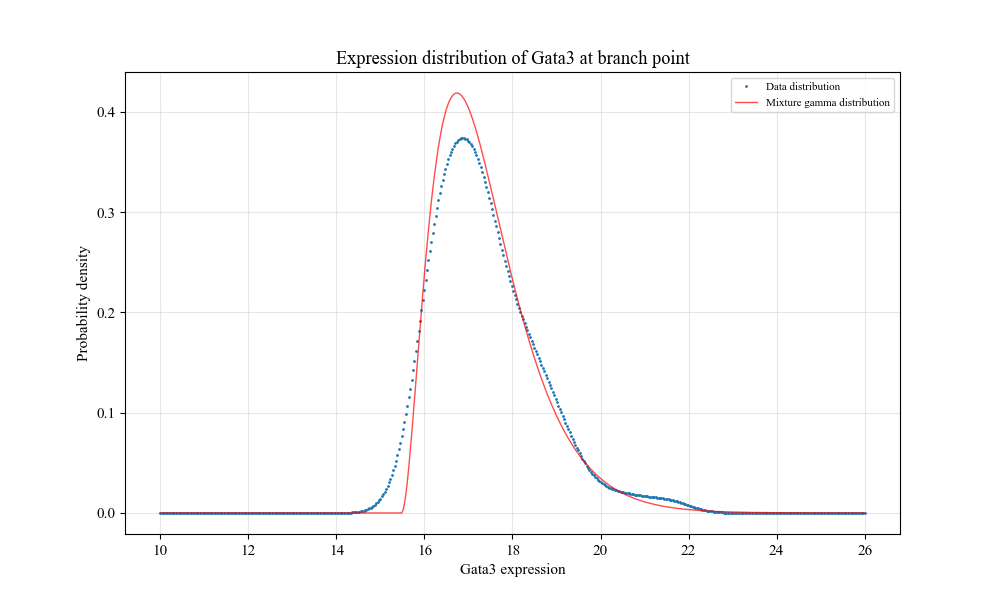

In [4]:
data = np.array(adata_X_5[index_gata3, :])
Density = gaussian_kde(data)
x = np.linspace(int(np.min(data)) - 5, int(np.max(data)) + 5, 500)
y = Density(x)

alpha1 = 2.898
loc = 15.481
beta1 = 1 / 0.662
y_fit = gamma.pdf(x, alpha1, loc, 1 / beta1)
# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
# 在图像上添加拟合参数
param_text = (
    f"$loc$ = {loc:.4f}\n" f"$\\alpha$ = {alpha1:.4f}\n" f"$\\beta$ = {beta1:.4f}"
)
# plt.text(
#     0.05,
#     0.95,
#     param_text,
#     transform=plt.gca().transAxes,
#     fontsize=10,
#     verticalalignment="top",
#     bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
# )
plt.legend(fontsize=8, loc="upper right")
plt.title(f"Expression distribution of Gata3 at branch point")
plt.xlabel(f"Gata3 expression")
plt.ylabel("Probability density")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig(
    save_path + "Gata3_2_branch_mixture_gamma.png", dpi=300, bbox_inches="tight"
)

#### Gata3分支后1的数据拟合

In [ ]:
data = np.array(adata_X_6[index_gata3, :])
Density = gaussian_kde(data)
x = np.linspace(int(np.min(data)) - 5, int(np.max(data)) + 5, 500)
y = Density(x)

# 输出最佳参数
w = 0.4425962963044753
alpha1 = 240.7903763099287
beta1 = 0.08565389318369372
alpha2 = 170.3633937101678
beta2 = 0.09358956751495484

y_fit = two_gamma(x, w, alpha1, beta1, alpha2, beta2)

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
# 在图像上添加拟合参数
param_text = (
    f"$w$ = {w:.4f}\n"
    f"$\\alpha_1$ = {alpha1:.4f}\n"
    f"$\\beta_1$ = {1/beta1:.4f}\n"
    f"$\\alpha_2$ = {alpha2:.4f}\n"
    f"$\\beta_2$ = {1/beta2:.4f}"
)
# plt.text(
#     0.05,
#     0.95,
#     param_text,
#     transform=plt.gca().transAxes,
#     fontsize=10,
#     verticalalignment="top",
#     bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
# )
plt.legend(fontsize=8, loc="upper right")
plt.title(f"Expression distribution of Gata3 after branch1")
plt.xlabel(f"Gata3 expression")
plt.ylabel("Probability density")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig(
    save_path + "Gata3_3_post_branch1_mixture_gamma.png", dpi=300, bbox_inches="tight"
)

#### Gata3分支后2的数据拟合

In [ ]:
data = np.array(adata_X_7[index_gata3, :])
density = gaussian_kde(data)
x = np.linspace(int(min(data)) - 2, int(max(data)) + 2, 500)
y = density(x)

initial_params = [0.5, 0.5, 2, 1, 2, 1, 2, 1]

# 使用 curve_fit 进行拟合
params, params_covariance = curve_fit(
    three_gamma,
    x,
    y,
    p0=initial_params,
    maxfev=10000000,
)

# 输出最佳参数
w1, w2, alpha1, beta1, alpha2, beta2, alpha3, beta3 = params

# 计算拟合的函数值
y_fit = three_gamma(x, *params)

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
# 在图像上添加拟合参数
param_text = (
    f"$w_1$ = {w1:.4f}\n"
    f"$w_2$ = {w2:.4f}\n"
    f"$\\alpha_1$ = {alpha1:.4f}\n"
    f"$\\beta_1$ = {1/beta1:.4f}\n"
    f"$\\alpha_2$ = {alpha2:.4f}\n"
    f"$\\beta_2$ = {1/beta2:.4f}\n"
    f"$\\alpha_3$ = {alpha3:.4f}\n"
    f"$\\beta_3$ = {1/beta3:.4f}"
)
# plt.text(
#     0.05,
#     0.95,
#     param_text,
#     transform=plt.gca().transAxes,
#     fontsize=10,
#     verticalalignment="top",
#     bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
# )
plt.legend(fontsize=8, loc="upper right")
plt.title(f"Expression distribution of Gata3 after branch2")
plt.xlabel(f"Gata3 expression")
plt.ylabel("Probability density")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig(
    save_path + f"Gata3_4_post_branch2_mixture_gamma.png", dpi=300, bbox_inches="tight"
)

#### Sox2分支前、中，后1的拟合

In [11]:
def plot_mixture_gamma(data, gene_name, index):
    time, time_name, time_title = time_mapping(index)
    density = gaussian_kde(data)
    x = np.linspace(int(min(data)) - 2, int(max(data)) + 2, 200)
    y = density(x)
    initial_params = [0.5, 2, 1, 2, 1]  # 初始参数猜测
    params, params_covariance = curve_fit(
        two_gamma, x, y, p0=initial_params, maxfev=5000
    )
    print("w =", params[0])
    print("alpha1 =", params[1])
    print("beta1 =", params[2])
    print("alpha2 =", params[3])
    print("beta2 =", params[4])
    # 输出最佳参数
    w, alpha1, beta1, alpha2, beta2 = params
    y_fit = two_gamma(x, *params)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
    plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
    # 在图像上添加拟合参数
    param_text = (
        f"$w$ = {w:.4f}\n"
        f"$\\alpha_1$ = {alpha1:.4f}\n"
        f"$\\beta_1$ = {1/beta1:.4f}\n"
        f"$\\alpha_2$ = {alpha2:.4f}\n"
        f"$\\beta_2$ = {1/beta2:.4f}"
    )
    # plt.text(
    #     0.05,
    #     0.95,
    #     param_text,
    #     transform=plt.gca().transAxes,
    #     fontsize=10,
    #     verticalalignment="top",
    #     bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
    # )

    plt.legend(fontsize=8, loc="upper right")
    # 控制Y轴的范围
    # plt.ylim(0, 0.3)
    plt.title(f"Expression distribution of {gene_name} {time_title}")
    plt.xlabel(f"{gene_name} expression")
    plt.ylabel("Probability density")
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.savefig(
        save_path + f"{gene_name}_{index}{time_name}_mixture_gamma_noparms.png",
        dpi=300,
        bbox_inches="tight",
    )

w = 0.8974323395881777
alpha1 = 62.96591762316247
beta1 = 0.3763641954612798
alpha2 = 178.23265754175975
beta2 = 0.09689448471990945


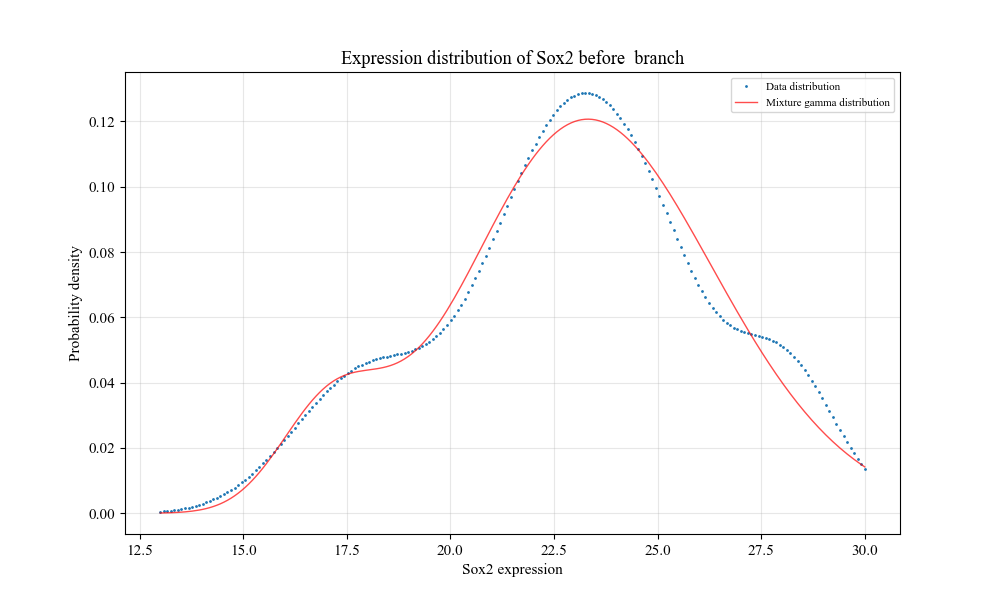

w = 0.5602260952265149
alpha1 = 189.40446677092427
beta1 = 0.12444625975058633
alpha2 = 627.5363960408555
beta2 = 0.044609441174423614


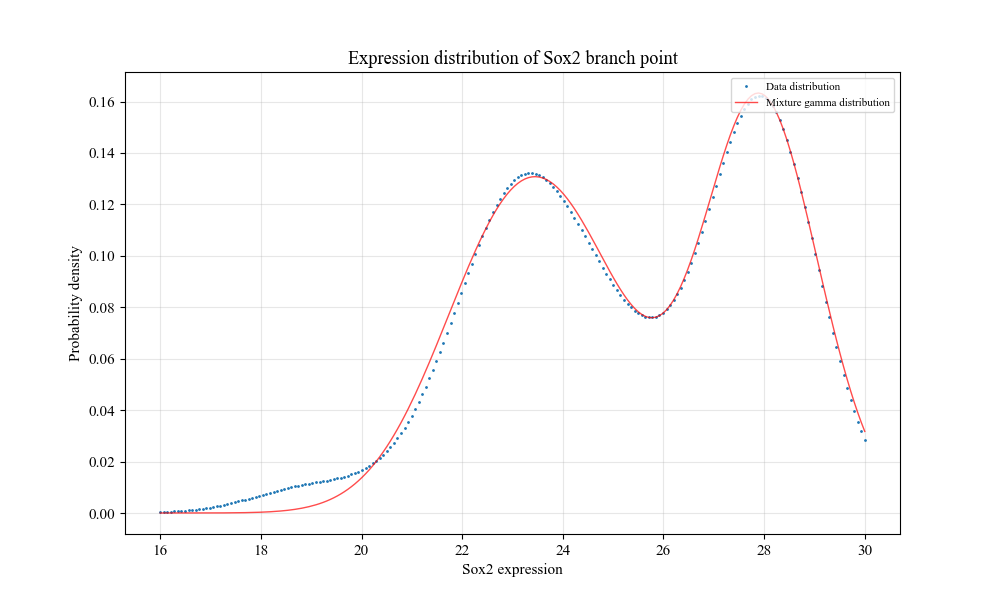

w = 0.36294066631160854
alpha1 = 100.72603793283974
beta1 = 0.18050047320712315
alpha2 = 63.79331978392633
beta2 = 0.39943489984709735


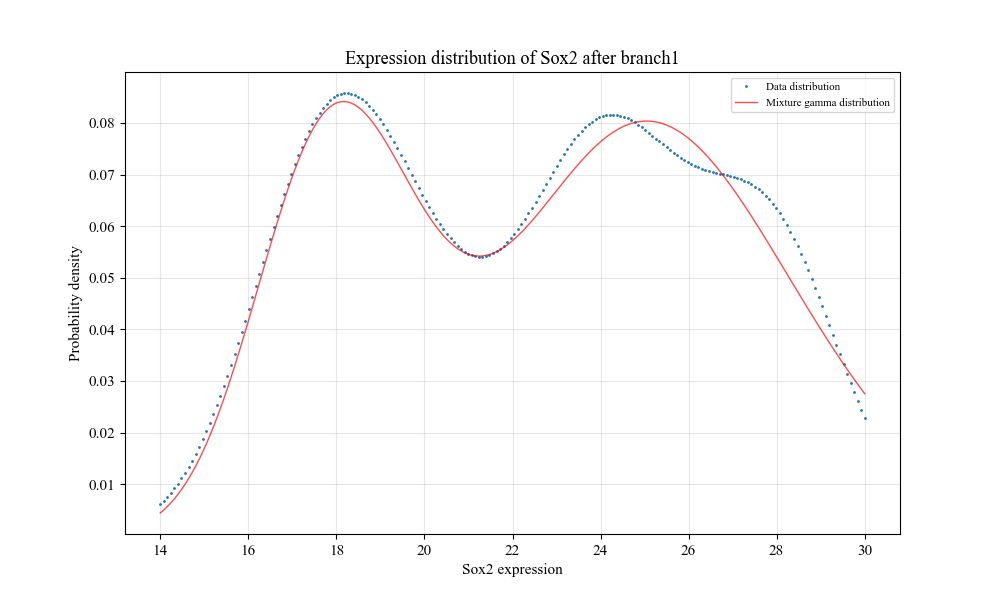

In [12]:
data_sets = [adata_X_4, adata_X_5, adata_X_6]
index_sets = [index_sox2]
names = ["Sox2"]

for name, index in zip(names, index_sets):
    for i, data_set in enumerate(data_sets, start=1):
        data = data_set[index, :]
        plot_mixture_gamma(data, name, i)

#### Sox2分支后2的拟合

In [ ]:
def three_gamma_loc(x, w1,  w2, alpha1, loc1, beta1,alpha2, loc2, beta2, alpha3, loc3, beta3):
    if w1 < 0 or w1 > 1 or w2 < 0 or w2 > 1 or w1 + w2 > 1:
        return np.zeros_like(x)
    return w1 * gamma.pdf(x, alpha1, loc1, beta1) + w2 * gamma.pdf(x, alpha2, loc2, beta2) + (1 - w1)*(1 - w2) * gamma.pdf(x, alpha3, loc3, beta3)

def three_gamma(x, w1,  w2, alpha1,beta1,alpha2,beta2, alpha3,beta3):
    if w1 < 0 or w1 > 1 or w2 < 0 or w2 > 1 or w1 + w2 > 1:
        return np.zeros_like(x)
    return w1 * gamma.pdf(x, alpha1,scale=beta1) + w2 * gamma.pdf(x, alpha2, scale=beta2) + (1 - w1)*(1 - w2) * gamma.pdf(x, alpha3, scale=beta3)


# 定义负对数似然函数
def neg_log_likelihood(params, data):
    w1, w2, alpha1, loc1, beta1, alpha2, loc2, beta2, alpha3, loc3, beta3 = params
    if w1 < 0 or w1 > 1 or w2 < 0 or w2 > 1 or w1 + w2 > 1:
        return np.inf
    else:
        pdf = w1 * gamma.pdf(data, alpha1, loc1, beta1) + w2 * gamma.pdf(data, alpha2, loc2, beta2) + (1 - w1)*(1 - w2) * gamma.pdf(data, alpha3, loc3, beta3)
        return -np.sum(np.log(pdf))

data=np.array(adata_X_7[index_sox2,:])
Density=gaussian_kde(data)
x=np.linspace(int(np.min(data))-5,int(np.max(data))+5,500)
y=Density(x)

# 最小化负对数似然函数
# init_params = [0.33, 0.33, 2, 0, 2, 4, 0, 1, 6, 0, 0.5]
# result = minimize(neg_log_likelihood, init_params, args=(data,), method='Nelder-Mead')
# print(result.x)
# w1, w2,alpha1, loc1, beta1, alpha2, loc2, beta2, alpha3, loc3, beta3 = result.x

# 使用 curve_fit 进行拟合three_gamma_loc
# initial_params=[0.5,0.5,2,1,2,2,1,2,1,1,1]
# bounds = ([0, 0, -np.inf, 0, 0, 0, -np.inf, 0, 0, -np.inf, 0], [1, 1, np.inf, np.inf, np.inf,np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])  # 参数的下界和上界
# params, params_covariance = curve_fit(three_gamma_loc, x, y, p0=initial_params, bounds=bounds, maxfev=10000000)
# w1, w2,alpha1, loc1, beta1, alpha2, loc2, beta2, alpha3, loc3, beta3 = params
# print(params)
# y_fit = three_gamma_loc(x, w1, w2, alpha1, loc1, scale1, alpha2, loc2, scale2, alpha3, loc3, scale3)

# 使用curve_fit进行拟合three_gamma
initial_params = [0.5, 0.5, 200, 2, 200, 2, 200, 2]
params, params_covariance = curve_fit(three_gamma, x, y, p0=initial_params, maxfev=10000000)
w1, w2, alpha1, beta1, alpha2, beta2, alpha3, beta3 = params
print(params)
y_fit = three_gamma(x, w1, w2, alpha1, beta1, alpha2, beta2, alpha3, beta3)
# alpha1=1.9238341282388587
# loc1=15.860869962698377
# scale1=0.8653704447224715

# alpha2=4434.786148634834
# loc2=-69.64373357921367
# scale2=0.021087863108553376

# alpha3=2110.418914671328
# loc3=16.718577748819502
# scale3=0.0052817028959464135

# w1=0.22689377413850706
# w2=0.773106225861493



# print(np.sum(np.abs(y-y_fit)))
print(np.sum((y-y_fit)**2))
# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
# # 绘制数据的直方图
# plt.hist(data, bins=20, density=True, alpha=0.5, color='orange', label="Data")
# sns.histplot(data, bins=20, kde=False, color='orange', label="Data",stat='probability')
# 在图像上添加拟合参数
param_text = (
    f"$w_1$ = {w1:.4f}\n"
    f"$w_2$ = {w2:.4f}\n"
    f"$\\alpha_1$ = {alpha1:.4f}\n"
    f"$loc_1$ = {loc1:.4f}\n"
    f"$\\beta_1$ = {1/scale1:.4f}\n"
    f"$\\alpha_2$ = {alpha2:.4f}\n"
    f"$loc_2$ = {loc2:.4f}\n"
    f"$\\beta_2$ = {1/scale2:.4f}\n"
    f"$\\alpha_3$ = {alpha3:.4f}\n"
    f"$loc_3$ = {loc3:.4f}\n"
    f"$\\beta_3$ = {1/scale3:.4f}"
)
# plt.text(
#     0.05,
#     0.95,
#     param_text,
#     transform=plt.gca().transAxes,
#     fontsize=10,
#     verticalalignment="top",
#     bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
# )
plt.legend(fontsize=8, loc="upper right")
plt.title(f"Expression distribution of Sox2 after branch2")
plt.xlabel(f"Sox2 expression")
plt.ylabel("Probability density")
plt.ylim(0, 0.3)
plt.grid(True, alpha=0.3)
plt.show()
# plt.savefig(
#     save_path + f"Sox2_4_post_branch2_mixture_gamma_loc.png", dpi=300, bbox_inches="tight"
# )

In [ ]:
def three_gamma_loc(x, w1,  w2, alpha1,beta1,alpha2, beta2, alpha3, beta3):
    if w1 < 0 or w1 > 1 or w2 < 0 or w2 > 1 or w1 + w2 > 1:
        return np.zeros_like(x)
    return w1 * gamma.pdf(x, alpha1,beta1) + w2 * gamma.pdf(x, alpha2, beta2) + (1 - w1)*(1 - w2) * gamma.pdf(x, alpha3, beta3)



data=np.array(adata_X_7[index_sox2,:])
Density=gaussian_kde(data)
x=np.linspace(int(np.min(data))-5,int(np.max(data))+5,500)
y=Density(x)

gmm=GaussianMixture(n_components=3)
gmm.fit(data.reshape(-1,1))
print(gmm.weights_)
print(gmm.means_)
print(gmm.covariances_)
# 把函数曲线画到图上
y_gmm=gmm.score_samples(x.reshape(-1,1))

# 最小化负对数似然函数
# init_params = [0.33, 0.33, 2, 0, 2, 4, 0, 1, 6, 0, 0.5]
# result = minimize(neg_log_likelihood, init_params, args=(data,), method='Nelder-Mead')
# print(result.x)
# w1, w2,alpha1, loc1, beta1, alpha2, loc2, beta2, alpha3, loc3, beta3 = result.x

# 使用 curve_fit 进行拟合
initial_params=[0.5,0.3,400,1,200,2,100,2]
bounds = ([0, 0, 0, 0, 0, 0, 0, 0], [1, 1, np.inf, np.inf, np.inf,np.inf,np.inf, np.inf])  # 参数的下界和上界
params, params_covariance = curve_fit(three_gamma_loc, x, y, p0=initial_params, maxfev=10000000,method='trf',bounds=bounds)
w1,  w2, alpha1,beta1,alpha2, beta2, alpha3, beta3 = params
print(params)



# 计算拟合的函数值
y_fit = three_gamma_loc(x,  w1,  w2, alpha1,beta1,alpha2, beta2, alpha3, beta3)
# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="", markersize=1, label="Data distribution")
plt.plot(x, y_fit, "r-", linewidth=1, alpha=0.7, label="Mixture gamma distribution")
plt.plot(x, y_gmm, "g-", linewidth=1, alpha=0.7, label="GMM distribution")
# # 绘制数据的直方图
# plt.hist(data, bins=30, density=True, alpha=0.5, color='orange', label="Data")
# sns.histplot(data, bins=30, kde=False, color='orange', label="Data",stat='probability')
# 在图像上添加拟合参数
param_text = (
    f"$w_1$ = {w1:.4f}\n"
    f"$w_2$ = {w2:.4f}\n"
    f"$\\alpha_1$ = {alpha1:.4f}\n"
    f"$loc_1$ = {loc1:.4f}\n"
    f"$\\beta_1$ = {1/scale1:.4f}\n"
    f"$\\alpha_2$ = {alpha2:.4f}\n"
    f"$loc_2$ = {loc2:.4f}\n"
    f"$\\beta_2$ = {1/scale2:.4f}\n"
    f"$\\alpha_3$ = {alpha3:.4f}\n"
    f"$loc_3$ = {loc3:.4f}\n"
    f"$\\beta_3$ = {1/scale3:.4f}"
)
plt.text(
    0.05,
    0.95,
    param_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
)
plt.legend(fontsize=8, loc="upper right")
plt.title(f"Expression distribution of Sox2 after branch2")
plt.xlabel(f"Sox2 expression")
plt.ylabel("Probability density")
# plt.ylim(0, 0.5)
plt.grid(True, alpha=0.3)
plt.show()
# plt.savefig(
#     save_path + f"Sox2_4_post_branch2_mixture_gamma_loc.png", dpi=300, bbox_inches="tight"
# )

In [ ]:
plt.figure()  # 创建新的图形
import numpy as np
from scipy.stats import gamma
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 定义混合伽马分布函数
def mix_gamma(x, a1, loc1, scale1, a2, loc2, scale2, a3, loc3, scale3, w1, w2):
    # return w1*gamma.pdf(x, a1, loc=loc1, scale=scale1) + w2*gamma.pdf(x, a2, loc=loc2, scale=scale2) + (1-w1-w2)*gamma.pdf(x, a3, loc=loc3, scale=scale3)
    return w1*gamma.pdf(x, a1, loc=loc1, scale=scale1) + w2*gamma.pdf(x, a2, loc=loc2, scale=scale2) + (1-w1)*(1-w2)*gamma.pdf(x, a3, loc=loc3, scale=scale3)

# 数据预处理，生成直方图数据
hist, bin_edges = np.histogram(data, bins=30, density=True)
x = (bin_edges[:-1] + bin_edges[1:]) / 2
y = hist

# 使用混合伽马分布进行拟合
p0 = [1, 0, 2, 1, 0, 2, 1, 0, 2, 0.1, 0.33]  # 初始参数
bounds = ([0, -np.inf, 0, 0, -np.inf, 0, 0, -np.inf, 0, 0.00001, 0.1], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 0.2, 0.5])  # 参数的下界和上界
param, _ = curve_fit(mix_gamma, x, y, p0, bounds=bounds, maxfev=10000000)
a1, loc1, scale1, a2, loc2, scale2, a3, loc3, scale3, w1, w2 = param

print(*param)
# 由于w1和w2的和可能不等于1，我们需要对它们进行归一化
w1, w2 = w1 / (w1 + w2), w2 / (w1 + w2)

print(f"Gamma distribution parameters: \n"
      f"a1={a1}, loc1={loc1}, scale1={scale1}\n"
      f"a2={a2}, loc2={loc2}, scale2={scale2}\n"
      f"a3={a3}, loc3={loc3}, scale3={scale3}\n"
      f"w1={w1}, w2={w2}")

# 绘制数据的直方图
plt.hist(data, bins=30, density=True, alpha=0.5, color='orange', label="Data")

# 绘制混合伽马分布的拟合曲线
x_fit = np.linspace(min(data), max(data), 1000)
y_fit = mix_gamma(x_fit, a1, loc1, scale1, a2, loc2, scale2, a3, loc3, scale3, w1, w2)
plt.plot(x_fit, y_fit, color='red', label="Fit")

plt.legend()
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import tensorflow as tf

# 混合伽马分布
def mixture_gamma_distribution(xs, shapes, scales, weights):
    ys = np.zeros_like(xs)
    for shape, scale, weight in zip(shapes, scales, weights):
        ys += weight * ((xs ** (shape - 1) * np.exp(-xs / scale)) / (scale ** shape * gamma(shape)))
    return ys


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import tensorflow as tf

# 混合伽马分布
def mixture_gamma_distribution(xs, shapes, scales, weights):
    ys = np.zeros_like(xs)
    for shape, scale, weight in zip(shapes, scales, weights):
        ys += weight * ((xs ** (shape - 1) * np.exp(-xs / scale)) / (scale ** shape * gamma(shape)))
    return ys

# 使用Adam优化器拟合混合伽马分布
def fit_mixture_gamma_distribution_1(
    xs,
    ys,
    n_components,
    learning_rate=0.0001,
    iterations=15000,
    tolerance=1e-5,
    patience=30,
):
    xs = tf.cast(xs, tf.float32)
    ys = tf.cast(ys, tf.float32)
    
    shapes = [tf.Variable(2.0 + i, dtype=tf.float32) for i in range(n_components)]
    scales = [tf.Variable(1.0 + i, dtype=tf.float32) for i in range(n_components)]
    raw_weights = [
        tf.Variable(1.0 / n_components, dtype=tf.float32) for _ in range(n_components)
    ]

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    losses = []
    no_improve_count = 0

    for i in range(iterations):
        with tf.GradientTape() as tape:
            softmax_weights = tf.nn.softmax(raw_weights)
            
            y_pred = tf.zeros_like(xs)
            for s, sc, w in zip(shapes, scales, softmax_weights):
                numerator = xs ** (s - 1) * tf.exp(-xs / sc)
                denominator = sc ** s * tf.exp(tf.math.lgamma(s))
                y_pred += w * (numerator / denominator)

            epsilon = 1e-10
            p = tf.clip_by_value(ys, epsilon, 1.0)
            q = tf.clip_by_value(y_pred, epsilon, 1.0)
            m = 0.5 * (p + q)
            loss = 0.5 * (
                tf.reduce_sum(p * tf.math.log(p / m))
                + tf.reduce_sum(q * tf.math.log(q / m))
            )
            
            # Add L2 regularization
            l2_lambda = 1e-4
            reg_loss = l2_lambda * sum(tf.nn.l2_loss(var) for var in shapes + scales + raw_weights)
            loss += reg_loss
            
            if tf.math.is_nan(loss):
                print(f"NaN detected at iteration {i}")
                break

        gradients = tape.gradient(loss, shapes + scales + raw_weights)
        optimizer.apply_gradients(zip(gradients, shapes + scales + raw_weights))

        losses.append(float(loss))

        if i > 0 and abs(losses[-1] - losses[-2]) < tolerance:
            no_improve_count += 1
        else:
            no_improve_count = 0

        if no_improve_count >= patience:
            print(f"Early stopping at iteration {i}, Loss: {loss:.6f}")
            break

        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss:.6f}")

    return (
        [s.numpy() for s in shapes],
        [sc.numpy() for sc in scales],
        softmax_weights.numpy(),
        losses,
    )

In [ ]:
# # 使用Adam优化器拟合混合伽马分布
# def fit_mixture_gamma_distribution_1(
#     xs,
#     ys,
#     n_components,
#     learning_rate=0.001,
#     iterations=15000,
#     tolerance=1e-5,
#     patience=30,
# ):
#     xs = tf.cast(xs, tf.float32)
#     ys = tf.cast(ys, tf.float32)
    
#     shapes = [tf.Variable(1.0 + 2 * i, dtype=tf.float32) for i in range(n_components)]
#     scales = [tf.Variable(1.5 + 2 * i, dtype=tf.float32) for i in range(n_components)]
#     raw_weights = [
#         tf.Variable(1.0 / n_components, dtype=tf.float32) for _ in range(n_components)
#     ]

#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     losses = []
#     no_improve_count = 0

#     for i in range(iterations):
#         with tf.GradientTape() as tape:
#             softmax_weights = tf.nn.softmax(raw_weights)
            
#             y_pred = tf.zeros_like(xs)
#             for s, sc, w in zip(shapes, scales, softmax_weights):
#                 numerator = xs ** (s - 1) * tf.exp(-xs / sc)
#                 denominator = sc ** s * tf.exp(tf.math.lgamma(s))
#                 y_pred += w * (numerator / denominator)

#             epsilon = 1e-10
#             p = tf.clip_by_value(ys, epsilon, 1.0)
#             q = tf.clip_by_value(y_pred, epsilon, 1.0)
#             m = 0.5 * (p + q)
#             loss = 0.5 * (
#                 tf.reduce_sum(p * tf.math.log(p / m))
#                 + tf.reduce_sum(q * tf.math.log(q / m))
#             )
            
#         gradients = tape.gradient(loss, shapes + scales + raw_weights)
#         optimizer.apply_gradients(zip(gradients, shapes + scales + raw_weights))

#         losses.append(float(loss))

#         if i > 0 and abs(losses[-1] - losses[-2]) < tolerance:
#             no_improve_count += 1
#         else:
#             no_improve_count = 0

#         if no_improve_count >= patience or not losses:
#             print(f"Early stopping at iteration {i}, Loss: {loss:.6f}")
#             break

#         if i % 1000 == 0:
#             print(f"Iteration {i}, Loss: {loss:.6f}")

#     return (
#         [s.numpy() for s in shapes],
#         [sc.numpy() for sc in scales],
#         softmax_weights.numpy(),
#         losses,
#     )


In [ ]:
data_sets = [adata_X_4, adata_X_5, adata_X_6]
index_sets = [index_gata3,index_sox2]
names = ["gata3","Sox2"]

for gene_name, index in zip(names, index_sets):
    for i, data_set in enumerate(data_sets, start=1):
        data = data_set[index, :]
        time, time_name, time_title = time_mapping(i)
        density = gaussian_kde(data)
        x = np.linspace(int(min(data)) - 2, int(max(data)) + 2, 200)
        y = density(x)
        estimated_shapes, estimated_scales, estimated_weights, losses = fit_mixture_gamma_distribution_1(x, y, n_components=2,learning_rate=0.02,iterations=20000)
        print(f"Estimated shapes: {estimated_shapes}")
        print(f"Estimated scales: {estimated_scales}")
        print(f"Estimated weights: {estimated_weights}")
        
        y_fit = mixture_gamma_distribution(x, estimated_shapes, estimated_scales, estimated_weights)
        param_text = (f'$w$ = {estimated_weights[0]:.4f}\n'
                  f'$\\alpha_1$ = {estimated_shapes[0]:.4f}\n'
                  f'$\\beta_1$ = {1/estimated_scales[0]:.4f}\n'
                  f'$\\alpha_2$ = {estimated_shapes[1]:.4f}\n'
                  f'$\\beta_2$ = {1/estimated_scales[1]:.4f}')
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', linestyle='', markersize=1, label='Data distribution') 
        plt.plot(x, y_fit, 'r-', linewidth=1, alpha=0.7,label='Mixture gamma distribution')
        plt.text(0.85, 0.85, param_text, transform=plt.gca().transAxes, fontsize=8,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
        plt.legend(fontsize=8, loc='upper right')
        plt.title(f"Expression distribution of {gene_name} {time_title}")
        plt.xlabel(f"{gene_name} expression")
        plt.ylabel("Probability density")
        plt.grid(True, alpha=0.3)
        plt.show()
        plt.savefig(save_path + f"{gene_name}_{index}{time_name}_mixture_gamma.png", dpi=300, bbox_inches='tight')
        